In [ ]:
%pip install --q fastkaggle

In [ ]:
from fastai.vision.all import *
from fastai.imports import *
from fastkaggle import *
import torch.nn as nn

In [ ]:
if iskaggle:
    path = Path("/kaggle/input/deforestationpreprocessed") / "archive"
else:
    path = Path.cwd() / "archive"

In [ ]:
md_df = pd.read_csv(path / "metadata.csv")

In [ ]:
md_df.head()

In [43]:
class_df = pd.read_csv(path / "class_dict.csv")
class_df.head()

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255


In [44]:
classes = class_df["name"].to_numpy(); classes

array(['urban_land', 'agriculture_land', 'rangeland', 'forest_land',
       'water', 'barren_land', 'unknown'], dtype=object)

In [47]:
def label_func(path):
    fname = path.name
    img_id = str(fname.split("_sat")[0])
    return path.parent / (img_id + "_mask_pre.png")

In [48]:
fnames = get_image_files(path / "train")
fnames = [fn for fn in fnames if fn.name.endswith("_sat.jpg")]
fnames[:5]

[Path('/kaggle/input/deforestationpreprocessed/archive/train/651774_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/170535_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/995492_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/576417_sat.jpg'),
 Path('/kaggle/input/deforestationpreprocessed/archive/train/923223_sat.jpg')]

In [49]:
#quelle https://github.com/YilmazKadir/Segmentation_Losses/blob/main/losses/topk.py
def flatten(input, target, ignore_index):
    num_class = input.size(1)
    input = input.permute(0, 2, 3, 1).contiguous()
    
    input_flatten = input.view(-1, num_class)
    target_flatten = target.view(-1)
    
    mask = (target_flatten != ignore_index)
    input_flatten = input_flatten[mask]
    target_flatten = target_flatten[mask]
    
    return input_flatten, target_flatten

class TopKLoss(nn.CrossEntropyLoss):
    def __init__(self, ignore_index=255, gamma=0.1):
        super().__init__(reduction='none')
        self.ignore_index = ignore_index
        self.gamma = gamma
      
    def forward(self, input, target):
        input, target = flatten(input, target, self.ignore_index)
        input_prob = torch.gather(softmax(input, dim=1), 1, target.unsqueeze(1))
        values, indices = torch.topk(input_prob, len(target)//10, largest=False)
        cross_entropy = super().forward(input, target)
        losses = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        loss = losses.mean()
        return loss

In [50]:
dls = SegmentationDataLoaders.from_label_func(
    path,
    bs=8,
    fnames=fnames,
    label_func=label_func,
    codes=classes,
    item_tfms=Resize(128),
    loss_func=TopKLoss(0.1)
)

In [51]:
# import torch
# import gc
# torch.cuda.empty_cache()
# gc.collect()

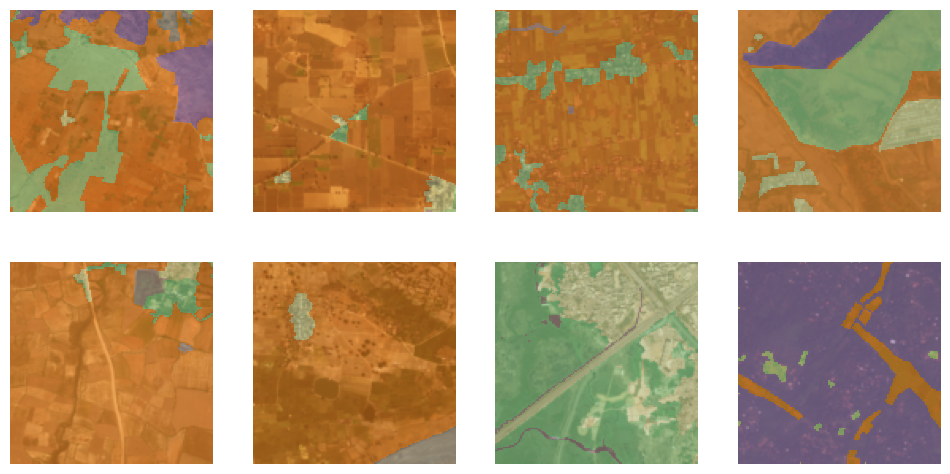

In [52]:
dls.show_batch()

In [54]:
import timm
from functools import partial
model = partial(timm.create_model, "timm/convnext_base.fb_in22k")

In [55]:
learner = unet_learner(dls, model, cbs=GradientAccumulation(4), metrics=[DiceMulti])

In [56]:
learner.fine_tune(10)

epoch,train_loss,valid_loss,dice_multi,time
0,1.481851,2.458493,0.118975,01:32


epoch,train_loss,valid_loss,dice_multi,time
0,1.045073,0.917627,0.377159,01:34
1,0.902095,0.943239,0.486238,01:33
2,0.804837,0.951289,0.421777,01:37
3,0.748942,0.785279,0.544442,01:23
4,0.681007,0.731398,0.602958,01:18
5,0.608238,0.660866,0.623502,01:19
6,0.539401,0.644090,0.682021,01:20
7,0.472974,0.608223,0.692676,01:18
8,0.434764,0.591827,0.698498,01:18
9,0.407291,0.597604,0.697985,01:18


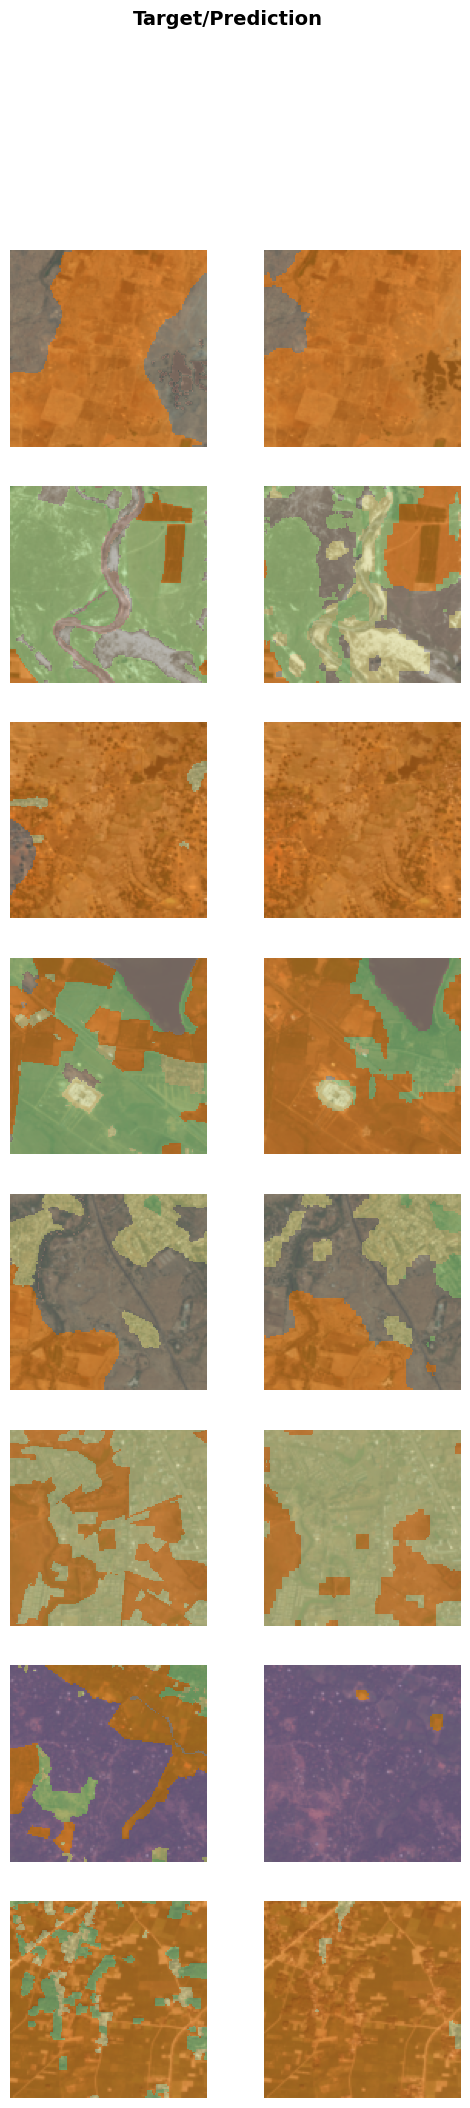

In [57]:
learner.show_results()

In [61]:
if iskaggle:
    out_path = Path("/kaggle/working/")
else: out_path = Path.cwd()

learner.export(out_path / "convnext_base_256px_8bs_68ds.pkl")

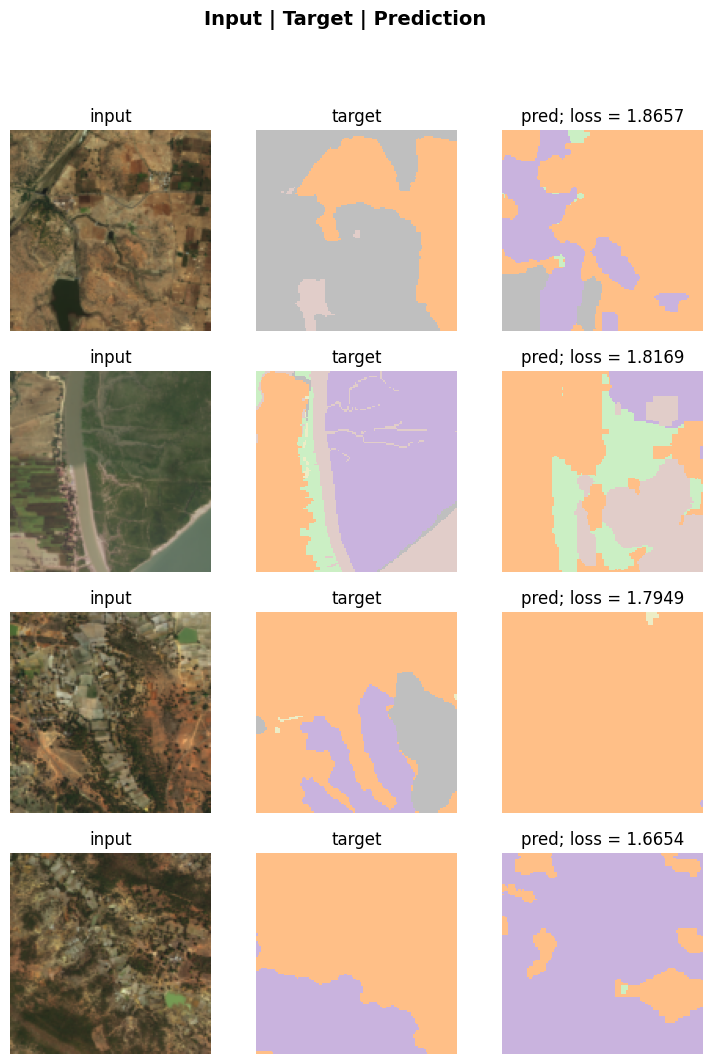

In [60]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(4)